#### Necessary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import random
import warnings
import itertools
import matplotlib
import seaborn as sns
from preprocessing import get_data_and_labels, create_features, perform_data_standardization, split_data, get_correlated_features
from EDA import time_series_plot, preprocessing_plot
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from custom_models import TrivialSystem, NearestMeansClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

#### Load Dataset

In [2]:
trainval_path = "./algerian_forest_dataset/train"
trainval_file = "algerian_fires_train.csv"
trainval_df = pd.read_csv(os.path.join(trainval_path, trainval_file))

In [3]:
test_data_path = "./algerian_forest_dataset/test"
test_file = "algerian_fires_test.csv"
test_df = pd.read_csv(os.path.join(test_data_path, test_file))

#### Baseline Evaluation

mean is 0.625
(60, 10)
0.48333333333333334
[[12 25]
 [ 6 17]]


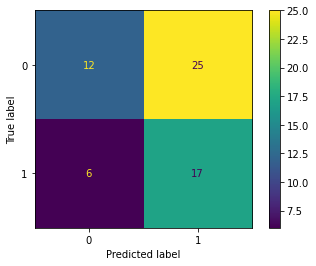

              precision    recall  f1-score   support

           0       0.67      0.32      0.44        37
           1       0.40      0.74      0.52        23

    accuracy                           0.48        60
   macro avg       0.54      0.53      0.48        60
weighted avg       0.57      0.48      0.47        60



In [4]:
### Baseline evaluation
# Trivial
tr_data, tr_labels = get_data_and_labels(trainval_df)
te_data, te_labels = get_data_and_labels(test_df)
trv = TrivialSystem(tr_data, tr_labels["Classes"])
ypred = trv.predict(te_data)
print(trv.score(ypred, te_labels["Classes"]))

cm = confusion_matrix(te_labels["Classes"], ypred)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

print(classification_report(te_labels["Classes"], ypred))

0.7833333333333333
[[36  1]
 [12 11]]


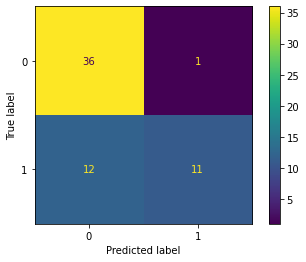

              precision    recall  f1-score   support

           0       0.75      0.97      0.85        37
           1       0.92      0.48      0.63        23

    accuracy                           0.78        60
   macro avg       0.83      0.73      0.74        60
weighted avg       0.81      0.78      0.76        60



In [5]:
#Nearest Means
nmc = NearestMeansClassifier(tr_data.drop(columns="Date").to_numpy(), tr_labels["Classes"])
nmc.fit()
ypred = nmc.predict(te_data.drop(columns="Date").to_numpy())
print(nmc.score(ypred, te_labels["Classes"]))
# print(nmc.score(nmc.predict(tr_data.drop(columns="Date").to_numpy()), tr_labels["Classes"]))

cm = confusion_matrix(te_labels["Classes"], ypred)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

print(classification_report(te_labels["Classes"], ypred))

#### Feature Engineering

In [6]:
# Load Data
trainval_data, trainval_labels = get_data_and_labels(trainval_df)
test_data, test_labels = get_data_and_labels(test_df)

#Feature Engineering
trainval_df_expanded = trainval_data.copy(deep=True)
trainval_df_expanded['Date'] = pd.to_datetime(trainval_df_expanded['Date'])

test_df_expanded = test_data.copy(deep=True)
test_df_expanded['Date'] = pd.to_datetime(test_df_expanded['Date'])

ignore_cols = ['Date','FFMC','DMC','DC','ISI','BUI'] 
create_features(trainval_df_expanded, window=4, ignore_cols=ignore_cols)
create_features(test_df_expanded, window=4,ignore_cols=ignore_cols)

trainval_df_expanded.drop(columns="Date", inplace=True)
test_df_expanded.drop(columns="Date", inplace=True)
print(trainval_df_expanded.shape, test_df_expanded.shape)

(184, 25) (60, 25)


#### Aanalysis of Feature Engineering

In [7]:
print(trainval_df_expanded.columns)
print(trainval_df_expanded.shape)
print(trainval_data.columns)
print(trainval_data.shape)

Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'max_Temperature', 'min_Temperature', 'mean_Temperature',
       'median_Temperature', 'max_RH', 'min_RH', 'mean_RH', 'median_RH',
       'max_Ws', 'min_Ws', 'mean_Ws', 'median_Ws', 'max_Rain', 'min_Rain',
       'mean_Rain', 'median_Rain'],
      dtype='object')
(184, 25)
Index(['Date', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI',
       'BUI'],
      dtype='object')
(184, 10)


#### StandarScaler and MinMaxScaler 

In [8]:
# Possible combination StandardScaler->normalize
Scaling = 1
Normalize = 0

In [9]:
if Scaling:
  #scaling methods: "StandardScaler", "MinMaxScaler"
  trainval_df_expanded_scaled, trainval_standard_scaler = perform_data_standardization(trainval_df_expanded, method="StandardScaler")
  # test_df_expanded_scaled, test_standard_scaler = PerformDataStandardization(test_df_expanded, method="StandardScaler")
  test_df_expanded_scaled = pd.DataFrame(trainval_standard_scaler.transform(test_df_expanded.copy(deep=True)), columns=trainval_df_expanded.columns)
else:
  trainval_df_expanded_scaled = trainval_df_expanded
  test_df_expanded_scaled = test_df_expanded

In [10]:
test_df_expanded_scaled.head() #just to verify

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,max_Temperature,...,mean_RH,median_RH,max_Ws,min_Ws,mean_Ws,median_Ws,max_Rain,min_Rain,mean_Rain,median_Rain
0,-1.870713,1.980690,1.689946,3.244829,-2.485551,-0.721869,-0.714654,-0.871962,-1.126666,-5.040591,...,-3.916664,-3.733846,-4.577717,-2.721609,-4.345608,-3.725492,-0.587232,0.501595,-0.565127,-0.517953
1,-0.861509,1.147043,0.126569,-0.497282,-1.749723,-0.901961,-1.199726,-1.528364,-1.373378,-5.040591,...,-3.916664,-3.733846,-4.577717,-2.721609,-4.345608,-3.725492,-0.587232,0.501595,-0.565127,-0.517953
2,-0.787806,2.433242,-1.357131,4.954002,-1.887627,-1.525131,-0.802394,-0.956857,-0.892752,-5.040591,...,-3.916664,-3.733846,-4.577717,-2.721609,-4.345608,-3.725492,-0.587232,0.501595,-0.565127,-0.517953
3,0.666428,-0.926276,-0.414046,-0.350891,0.915288,-0.855728,-0.703814,-0.931904,-1.098718,-5.040591,...,-3.916664,-3.733846,-4.577717,-2.721609,-4.345608,-3.725492,-0.587232,0.501595,-0.565127,-0.517953
4,-1.970677,-0.392009,-0.090191,1.709538,-0.517220,-1.178294,-0.707148,-1.542911,-0.630186,-0.304893,...,1.780646,2.375733,0.852924,-0.347576,0.164169,-0.034305,2.914726,-0.850087,3.671410,4.606363


In [11]:
if Normalize:
  trainval_df_expanded_scaled = pd.DataFrame(normalize(trainval_df_expanded_scaled), columns=trainval_df_expanded.columns)
  test_df_expanded_scaled = pd.DataFrame(normalize(test_df_expanded_scaled), columns=trainval_df_expanded.columns)

##### Analysis of Standardization and Normalization

Mean:  33.03810061858696  Standard Deviation:  9.206957355210145
mean + std:  42.2450579737971
mean - std:  23.831143263376816


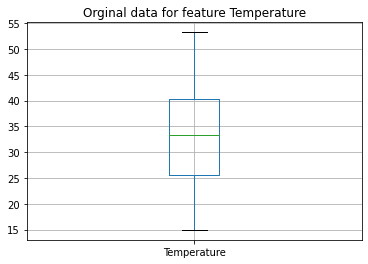

In [12]:
preprocessing_plot(trainval_data,title ='Orginal data for feature Temperature')

Mean:  4.61738135649131e-16  Standard Deviation:  1.0027285180318337
mean + std:  1.0027285180318342
mean - std:  -1.0027285180318333


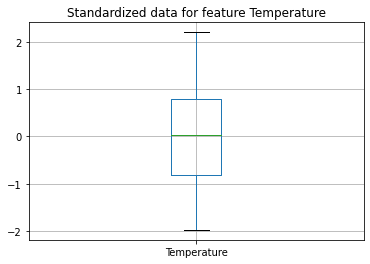

In [13]:
preprocessing_plot(trainval_df_expanded_scaled,title ='Standardized data for feature Temperature')

Mean:  0.4726582498651085  Standard Deviation:  0.24049771822377639
mean + std:  0.7131559680888849
mean - std:  0.23216053164133213


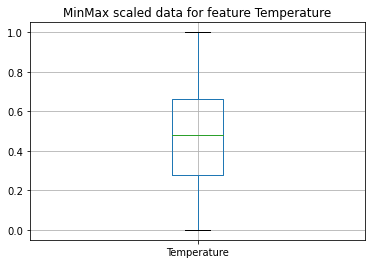

In [14]:

trainval_df_expanded_minmax, _ = perform_data_standardization(trainval_df_expanded, method="MinMaxScaler")
preprocessing_plot(trainval_df_expanded_minmax,title ='MinMax scaled data for feature Temperature')

#### Feature Selection/Reduction

In [15]:
### Perform Feature Selection or Reduction
fsr = "pca" #possible options 'pca', 'sfs', 'corr', 'lda'
nc = 4
thresh = 0.5
if fsr == 'pca':
  pca = PCA(n_components=nc)
  pca.fit(trainval_df_expanded_scaled)
  cols = [f"PC-{i}" for i in range(nc)]
  trainval_df_expanded_fsr = pd.DataFrame(pca.transform(trainval_df_expanded_scaled), columns=cols)
  test_df_expanded_fsr = pd.DataFrame(pca.transform(test_df_expanded_scaled), columns=cols)
  # print(trainval_df_expanded_fsr.describe())
elif fsr == 'sfs':
  #TODO: Use sklearn SequentialFeatureSelection, had tried it with NearestMeans but since it is used just for baseline removed currently
  print("Sequential Feature Selection is not implemented in latest code")
elif fsr == 'corr':
  corr_features = get_correlated_features(trainval_df_expanded_scaled, threshold=thresh)
  trainval_df_expanded_fsr = trainval_df_expanded_scaled[trainval_df_expanded_scaled.columns[~trainval_df_expanded_scaled.columns.isin(corr_features)]]
  test_df_expanded_fsr = test_df_expanded_scaled[test_df_expanded_scaled.columns[~test_df_expanded_scaled.columns.isin(corr_features)]]

  ## plot

  fig = plt.figure(figsize = (20, 25))
  j = 0
  for i in trainval_df_expanded_fsr.columns:
      plt.subplot(6, 4, j+1)
      j += 1
      sns.distplot(trainval_df_expanded_fsr[i][trainval_labels['Classes']==0], color='g', label = 'no fire')
      sns.distplot(trainval_df_expanded_fsr[i][trainval_labels['Classes']==1], color='r', label = 'fire')
      plt.legend(loc='best')
  fig.suptitle('Data Analysis')
  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.show()
else:
  trainval_df_expanded_fsr = trainval_df_expanded_scaled
  test_df_expanded_fsr = test_df_expanded_scaled
  #do nothing

#### Model Selection And HyperParameter tuning

In [16]:
plt.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams.update({'font.size': 10})


# make_parameter_grid adapted from:
# https://stackoverflow.com/questions/69300562/how-to-define-the-grid-for-using-grid-search-from-scratch-in-python
def make_parameter_grid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

def hyperparameter_tuning(model_lists, hyperparameters, trainval_data, trainval_labels):
  best_params = dict()

  #trainval
  for m in model_lists:
    # print(f"m - {m}")
    ds = make_parameter_grid(hyperparameters[m])
    tuned_params = dict() #move in later
    for idx, params in enumerate(ds):
      # print(f"idx- {idx} , params - {params}")
      # tscv = KFold(n_splits=5, shuffle=False)
      tscv = KFold(n_splits=5, shuffle=False)
      # tscv = TimeSeriesSplit(n_splits=5, gap=4)

      score_list = []
      #Below snippet follows sklearn KFold example codes
      for train_index, test_index in tscv.split(trainval_data):
        # print(f"indices: {train_index, test_index}")
        X_train, X_test = trainval_data.iloc[train_index], trainval_data.iloc[test_index]
        y_train, y_test = trainval_labels.iloc[train_index], trainval_labels.iloc[test_index]
        
        model = globals()[m](**params)
        model.fit(X_train, y_train)
      
        score = model.score(X_test, y_test)
      
        score_list.append(score)
      
      avg_score = np.mean(score_list)
      tuned_params[m+'_params_'+ str(idx)] = (params,avg_score)
    
    best_list = []
    for k,v in tuned_params.items():
      # print(k, v)
      best_list.append((v[1], v[0], k))
    # print(f"best list: {best_list}")
    s, p, k = max(best_list, key=lambda x:x[0])
    best_params[m] = (p,s)

  # print(f"Tuned Params for {m}, {tuned_params}")
  print(f"best of tuned params: {best_params}")
  return best_params

In [17]:
save_loc = "./analysis/fe_stdscale_timeseries/fe_stdscale_timeseries_"
#test
def test(model_lists, best_params, trainval_data, trainval_labels, test_data, test_labels):
  for m in model_lists:
    p = best_params[m][0]
    # print(m, p, best_params[m])
    model = globals()[m](**p)
    model.fit(trainval_data, trainval_labels)
    ypred = model.predict(trainval_data)
    train_score = model.score(trainval_data, trainval_labels)
    ypred = model.predict(test_data)
    test_score = model.score(test_data, test_labels)
    print(f"Performance for {m} with params {p}")
    print(f"Training accuracy: {train_score}, Test accuracy {test_score}")
    print(classification_report(test_labels, ypred, target_names = ["No Fire", "Fire"]))

    if not hasattr(model, 'decision_function'):
      y_score = model.predict_proba(test_data)
      fpr, tpr, _ = roc_curve(test_labels, y_score[:,1], pos_label=model.classes_[1])
      roc_auc =  auc(fpr, tpr)
    else:
      y_score = model.decision_function(test_data)
      fpr, tpr, _ = roc_curve(test_labels, y_score, pos_label=model.classes_[1])
      roc_auc =  auc(fpr, tpr)

    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label="ROC Curve (area=%0.2f)"%roc_auc)
    # plt.savefig(f"{save_loc}roc_curve_{m}.png")
    cm = confusion_matrix(test_labels, ypred)
    print(cm)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    cm_display.ax_.set_title(m + str(p))
    # plt.savefig(f"{save_loc}cm_{m}.png")
    # plt.show()
    print()
  

best of tuned params: {'KNeighborsClassifier': ({'n_neighbors': 4, 'weights': 'distance'}, 0.86996996996997), 'LogisticRegression': ({'penalty': 'l2', 'C': 1.0}, 0.8483483483483484), 'SVC': ({'kernel': 'linear', 'C': 10, 'gamma': 'auto'}, 0.8591591591591591), 'Perceptron': ({'penalty': 'l2', 'shuffle': False}, 0.6753753753753754), 'GaussianNB': ({}, 0.7995495495495496), 'RidgeClassifier': ({}, 0.8483483483483484), 'DecisionTreeClassifier': ({}, 0.8375375375375376), 'GradientBoostingClassifier': ({}, 0.8645645645645645), 'MLPClassifier': ({'hidden_layer_sizes': (6, 4), 'max_iter': 100, 'shuffle': False, 'activation': 'tanh', 'alpha': 0.0001}, 0.6698198198198198)}
Performance for KNeighborsClassifier with params {'n_neighbors': 4, 'weights': 'distance'}
Training accuracy: 1.0, Test accuracy 0.65
              precision    recall  f1-score   support

     No Fire       0.64      1.00      0.78        37
        Fire       1.00      0.09      0.16        23

    accuracy                   

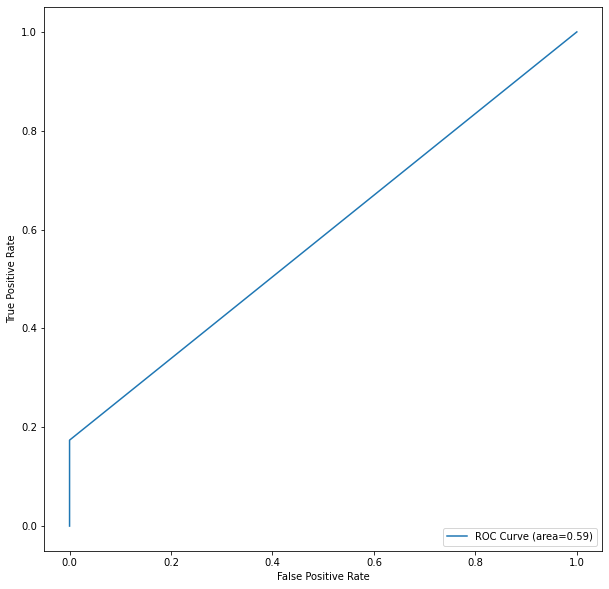

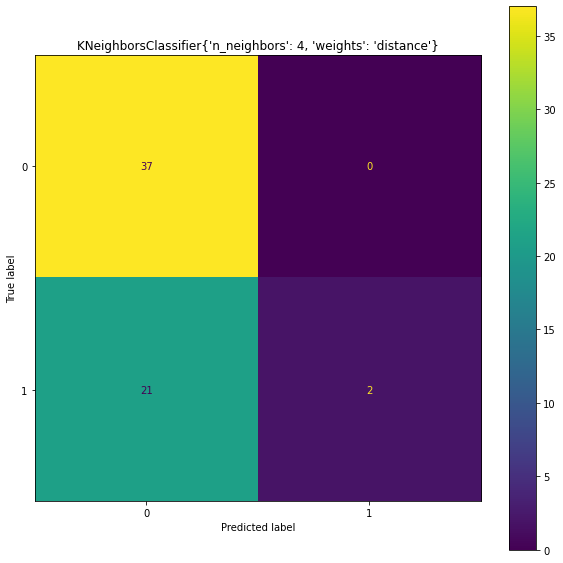

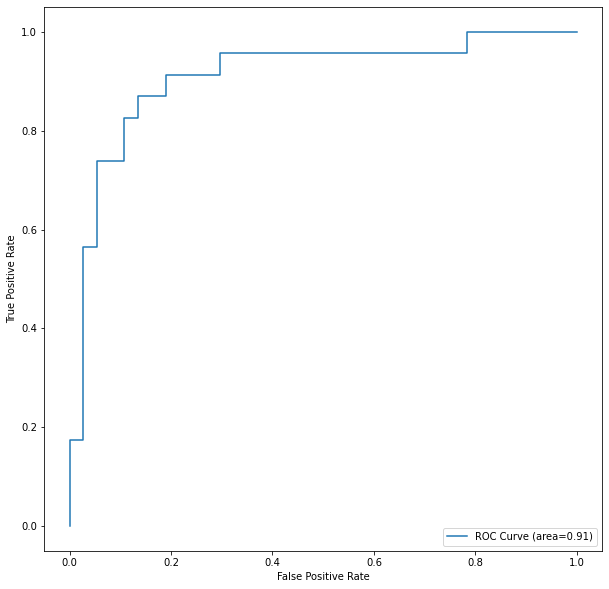

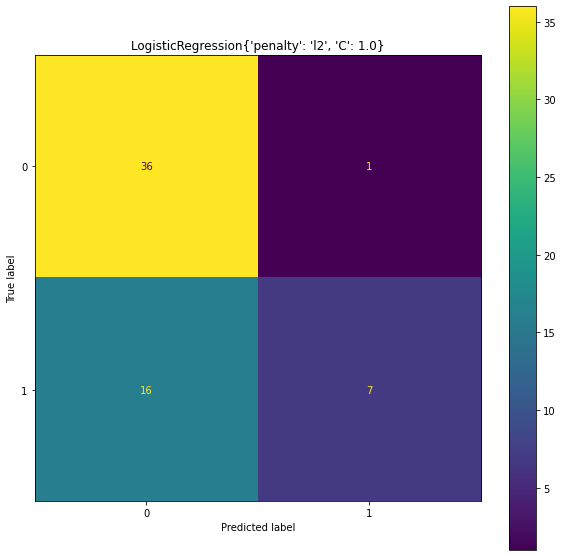

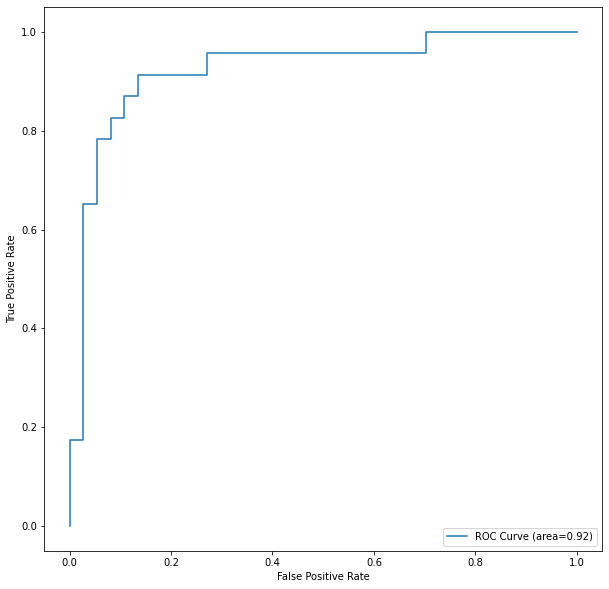

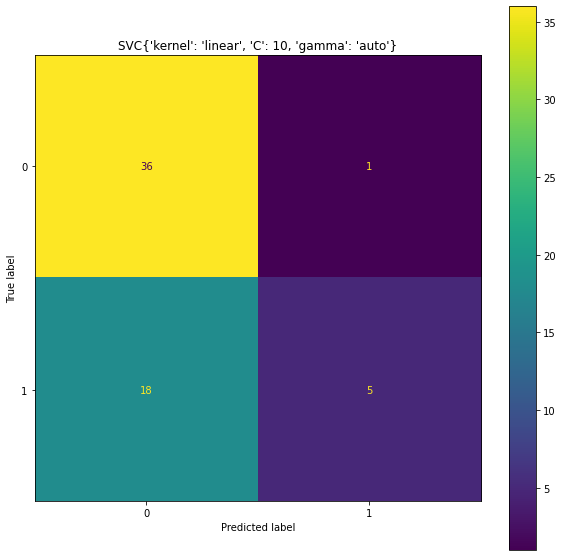

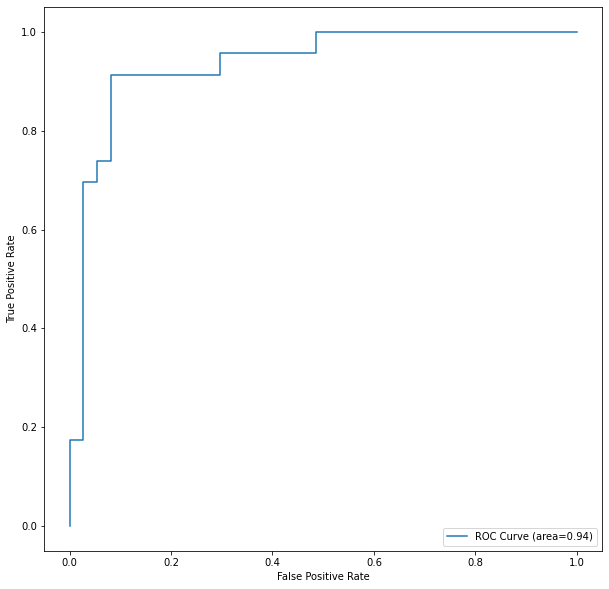

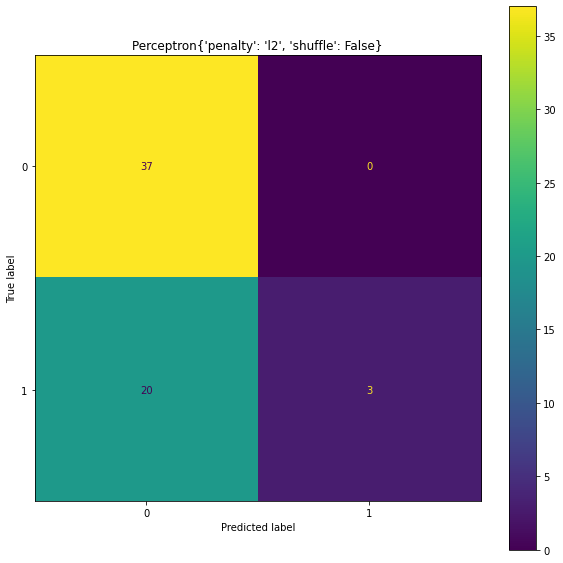

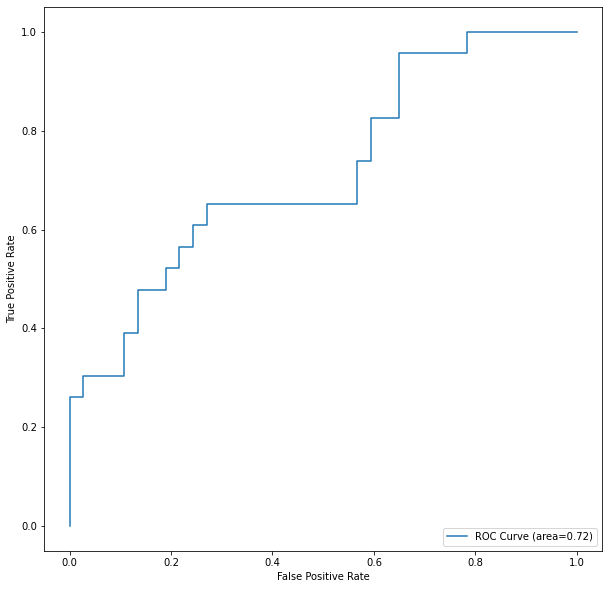

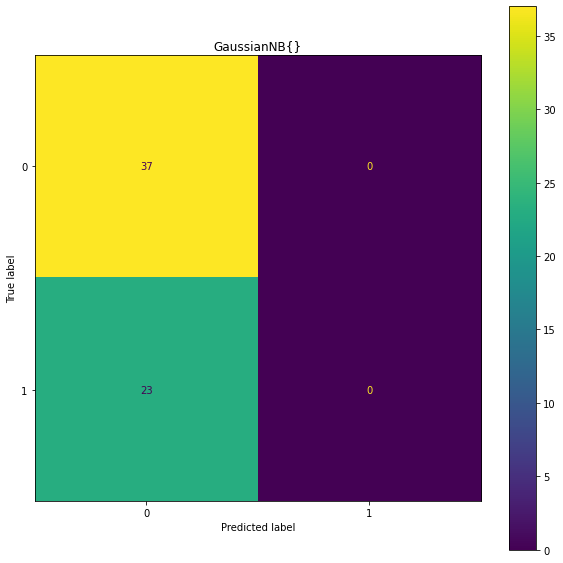

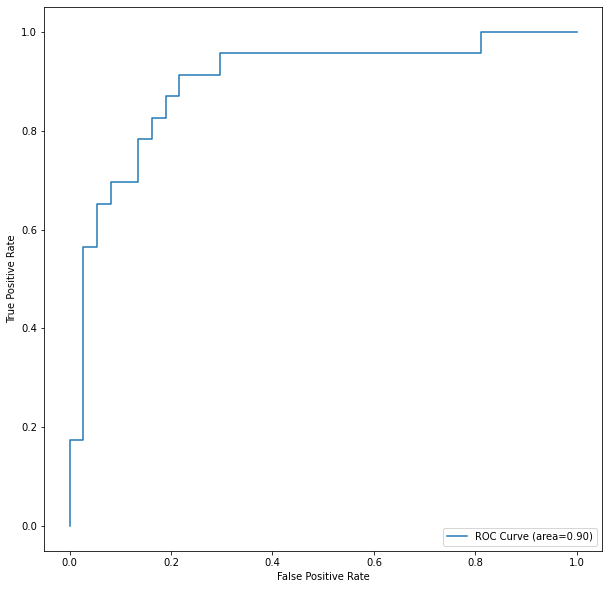

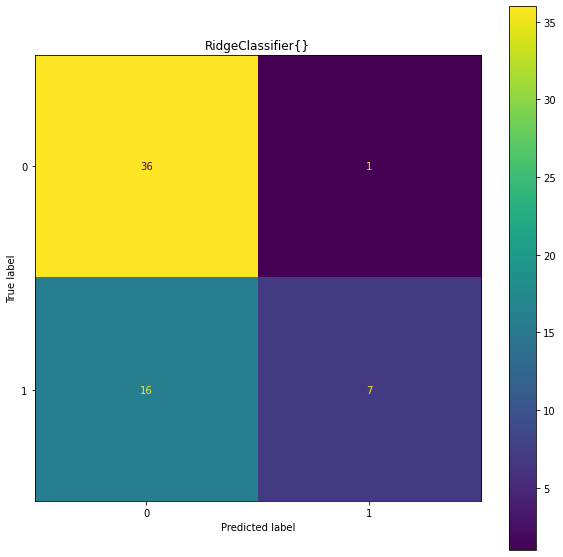

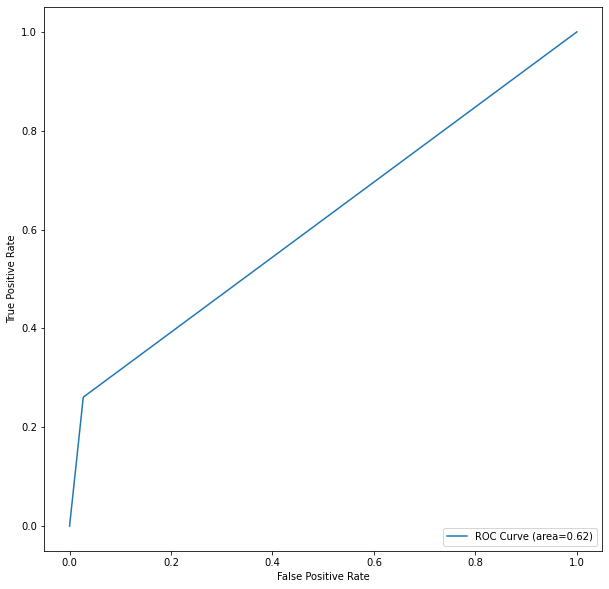

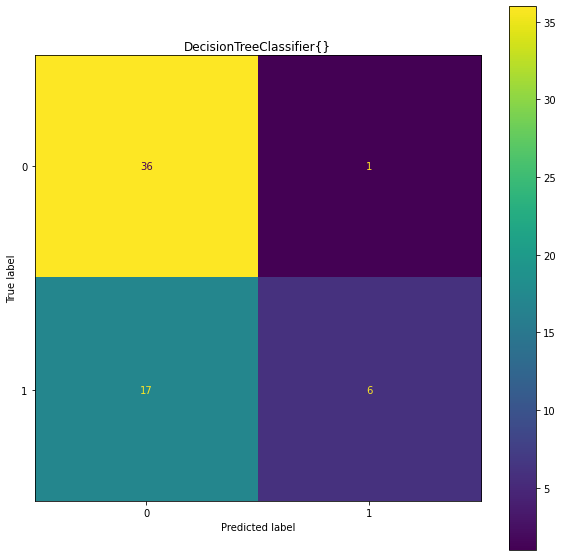

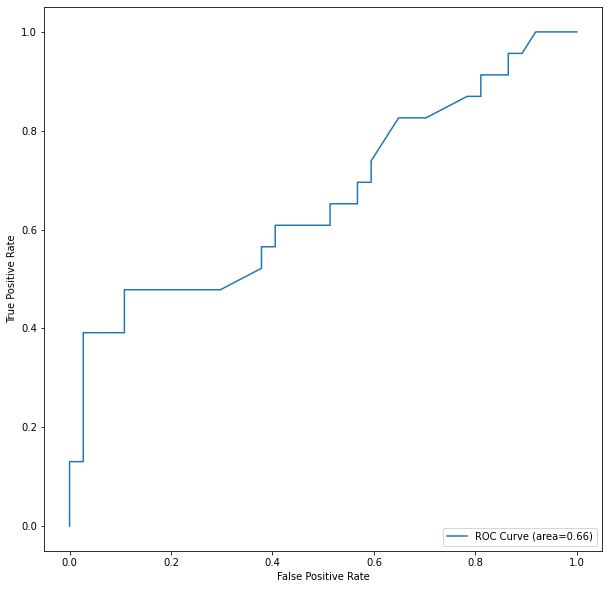

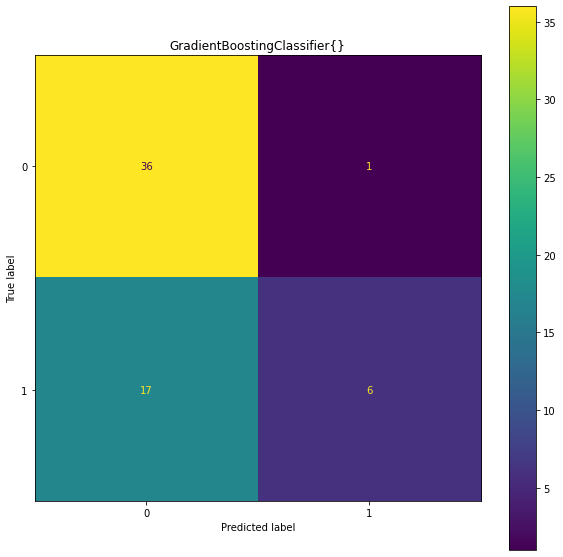

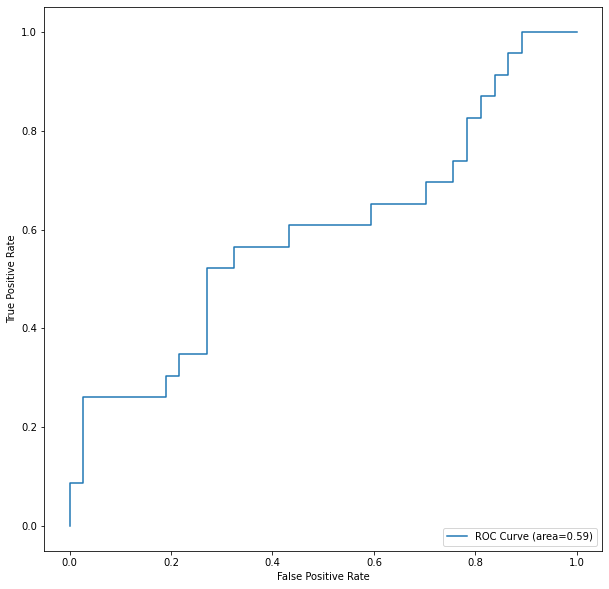

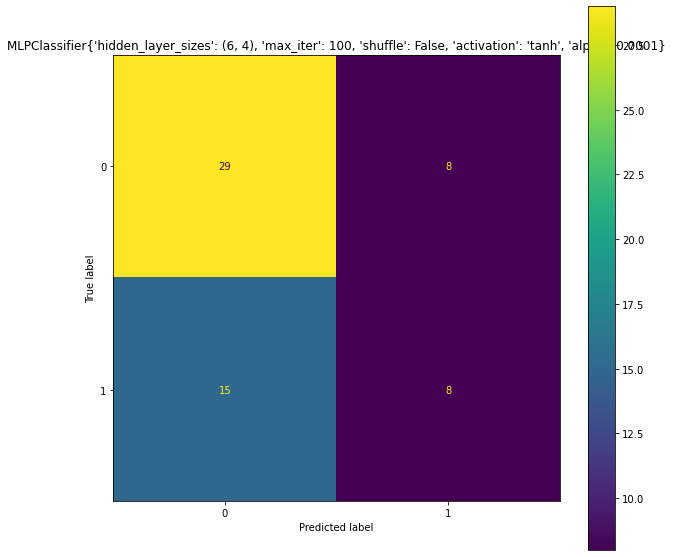

In [18]:
####Run train and test by tuning below hyper parameters

model_lists = ["KNeighborsClassifier", "LogisticRegression", "SVC", "Perceptron", 
               "GaussianNB", "RidgeClassifier","DecisionTreeClassifier", "GradientBoostingClassifier",
               "MLPClassifier"]
# model_lists = ["KNeighborsClassifier"]

hyperparameters = dict()
hyperparameters["KNeighborsClassifier"] = {"n_neighbors":[3, 4, 5, 6], "weights":["uniform", "distance"]}
hyperparameters["LogisticRegression"] = {"penalty": ["l2"], "C": [1.0, 1.5, 2.0]}
if fsr == "pca" or fsr == "corr":
  hyperparameters["SVC"] = {"kernel": ["linear","rbf"], "C": [1,10], "gamma": ["auto"]}
else:
    hyperparameters["SVC"] = {"kernel": ["linear", "rbf", "poly"], "C": [1, 10, 100], "gamma": [1e-3, 1e-4]}
hyperparameters["Perceptron"] = {"penalty":["l2"], "shuffle": [False]}
hyperparameters["GaussianNB"] = {}
hyperparameters["RidgeClassifier"] = {}
hyperparameters["DecisionTreeClassifier"] = {}
hyperparameters["GradientBoostingClassifier"] = {}
hyperparameters["MLPClassifier"] = {"hidden_layer_sizes":[(5,3), (6,4)],"max_iter":[100],"shuffle":[False], 
                                    "activation":["relu", "logistic","tanh"], "alpha":[0.0001, 0.001, 0.01]}

model_best_params_ = hyperparameter_tuning(model_lists, hyperparameters, trainval_df_expanded_fsr, trainval_labels)
test(model_lists, model_best_params_, trainval_df_expanded_fsr, trainval_labels, test_df_expanded_fsr, test_labels)

#### CODE ENDS HERE

#### ACKNOWLEDGEMENTS

1. Thanks to the author and contributors to the [scikit-learn](https://scikit-learn.org/stable/about.html) library for scientific computing. Our work highly relies on the API's for preprocessing, feature engineering, model selection.
2. Thanks to the author and contributors of [Pandas](https://pandas.pydata.org/) library for fast data analysis framework. Our work relies on the Pandas API for reading, and data analysis
3. We also are thankful to the community members at [StackOverflow](https://stackoverflow.com/) and [medium](https://medium.com/) contributing and sharing their knowledge and experience for further advancement of the community